NOTE: This model is made for learning purposes, it would have better validation mean absolute percentage error without datas from early history of btc since they are making too much noise.

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt


# Loading data set.
df = pd.read_csv('/Users/oguzhanengin/Desktop/MY PYTHON/MY DATAS/Bitcoin Historical Data - Investing.csv', sep=',')

In [2]:
# Analyzing and cleaning data set.
df = df.iloc[:-40, 1:]
df.tail()

,Price,Open,High,Low,Vol.,Change %
3980,8.4,7.4,9.3,7.2,64.05K,13.21%
3981,7.4,7.2,7.5,7.0,29.28K,3.78%
3982,7.2,6.7,7.4,6.7,35.28K,6.88%
3983,6.7,6.1,6.8,6.0,23.87K,9.31%
3984,6.1,5.6,6.5,5.6,31.11K,9.48%


In [3]:
df.dropna()


,Price,Open,High,Low,Vol.,Change %
0,"39,649.0","39,709.0","39,852.0","39,291.0",339.50M,-0.15%
1,"39,709.0","40,487.0","40,792.0","39,200.0",421.30M,-1.91%
2,"40,482.0","41,370.0","42,969.0","39,793.0",493.05M,-2.14%
3,"41,368.0","41,499.0","42,203.0","40,915.0",382.84M,-0.33%
4,"41,503.0","40,809.0","41,746.0","40,585.0",268.28M,1.72%
...,...,...,...,...,...,...
3980,8.4,7.4,9.3,7.2,64.05K,13.21%
3981,7.4,7.2,7.5,7.0,29.28K,3.78%
3982,7.2,6.7,7.4,6.7,35.28K,6.88%
3983,6.7,6.1,6.8,6.0,23.87K,9.31%


In [4]:
df['Vol.'] = df['Vol.'].str.replace('K', '000')
df['Vol.'] = df['Vol.'].str.replace('M', '000000')
df['Vol.'] = df['Vol.'].str.replace('B', '000000000')
df['Vol.'] = df['Vol.'].str.replace(',', '')
df['Vol.'] = df['Vol.'].str.replace('.', '')
df['Vol.'] = df['Vol.'].str.lstrip('0')
df['Vol.'] = df['Vol.'].str.strip()
df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.strip()
df['Change %'] = df['Change %'].str.replace(',', '')
df['High'] = df['High'].str.replace(',', '')
df['High'] = df['High'].str.strip()
df['Low'] = df['Low'].str.strip()
df['Low'] = df['Low'].str.replace(',', '')
df['Price'] = df['Price'].str.strip()
df['Price'] = df['Price'].str.replace(',', '')
df['Open'] = df['Open'].str.strip()
df['Open'] = df['Open'].str.replace(',', '')

df.head()

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_1997/1434400543.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Vol.'] = df['Vol.'].str.replace('.', '')


,Price,Open,High,Low,Vol.,Change %
0,39649.0,39709.0,39852.0,39291.0,33950000000,-0.15
1,39709.0,40487.0,40792.0,39200.0,42130000000,-1.91
2,40482.0,41370.0,42969.0,39793.0,49305000000,-2.14
3,41368.0,41499.0,42203.0,40915.0,38284000000,-0.33
4,41503.0,40809.0,41746.0,40585.0,26828000000,1.72


In [5]:
df = df.astype('float32')
type(df.iloc[2, 2])

numpy.float32

In [6]:
# Normalizing data.
normalization_list = []

for column in df.columns:
    normalization_list.append([column, df[column].max()])
    df[column] = df[column] / df[column].max()


df = df.iloc[::-1]
df = df.iloc[500:, :]
df.shape

(3485, 6)

In [7]:
# Creating input array for lstm layers.
NUMBEROFDAYSFORDATA = 97

btc_data_array = np.zeros((df.shape[0] - 96, NUMBEROFDAYSFORDATA, df.shape[1]))


for row in range(btc_data_array.shape[0]):

    for column in range(btc_data_array.shape[1]):

        for feature in range(btc_data_array.shape[2]):
            
            btc_data_array[row, column, feature] = df.iloc[column + row, feature]

In [8]:
from sklearn.model_selection import train_test_split

# Splitting data into test train and validation. + shuffle.
test_datas = btc_data_array[:-30:-1, :, :]

btc_data_array = btc_data_array[:-30, :, :]


np.random.shuffle(btc_data_array)

X = btc_data_array[:, :90, :]

y = btc_data_array[:, 90:, 0]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=8)


In [12]:
# Defining a function for creating model with hyperparameters.
def create_btc_model(hp):

    model = Sequential()

    hp_units_first = hp.Int('units_first_hidden', min_value=32, max_value=80, step=16)
    hp_units_second = hp.Int('units_second_hidden', min_value=32, max_value=80, step=16)
    hp_units_third = hp.Int('units_third_hidden', min_value=32, max_value=80, step=16)
    hp_drop_rate = hp.Float('rate', min_value=0.4, max_value=0.6, step=0.1)
    hp_recurrent_drop_rate = hp.Float('recurrent_rate', min_value=0.3, max_value=0.6, step=0.1)

    model.add(LSTM(units=hp_units_first, input_shape=(90, 6), activation='relu', return_sequences=True, recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(LSTM(units=hp_units_second, activation='relu', return_sequences=True, recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(LSTM(units=hp_units_third, activation='relu', recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(Dense(7, activation='relu'))

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

    return model



In [17]:
# Creating a tuner(RandomSearch) for model.
tuner = kt.RandomSearch(create_btc_model,
                    objective= kt.Objective('val_mean_absolute_percentage_error', 'min'),
                    max_trials=5,
                    directory='my_tuner',
                    project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_tuner/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_tuner/intro_to_kt/tuner0.json


In [25]:
# Tuning the model.
tuner.search(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation))

NOTE1: Since output consist of 7 elements, this models validation mean absolute percentage error is (243.5 / 7) = %34.78 == Model is too small with 50 epochs.

NOTE2: It is clear that model is not overfitting, so I'll make it bigger and do one more tuning after this.

In [18]:
# Getting best hyperparameters and tuning the model.
best_hyps = tuner.get_best_hyperparameters()[0]
model = create_btc_model(best_hyps)

In [27]:
# Training the best model.
history = model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_validation, y_validation))

Epoch 1/50
84/84 [==============================] - 23s 219ms/step - loss: 0.0484 - mean_absolute_percentage_error: 1545.6516 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 1544.0795
Epoch 2/50
84/84 [==============================] - 19s 230ms/step - loss: 0.0173 - mean_absolute_percentage_error: 1126.6555 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 837.0806
Epoch 3/50
84/84 [==============================] - 19s 223ms/step - loss: 0.0107 - mean_absolute_percentage_error: 772.8625 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 681.2914
Epoch 4/50
84/84 [==============================] - 18s 209ms/step - loss: 0.0092 - mean_absolute_percentage_error: 625.3347 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 580.5184
Epoch 5/50
84/84 [==============================] - 18s 215ms/step - loss: 0.0081 - mean_absolute_percentage_error: 554.9450 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 497.6417
Epoch 6/50
84/84 [========================

In [19]:
# Prediction and renormalization.
evaluation_data = np.copy(test_datas[:, 90:, 0]) * normalization_list[0][1]

predictions = model.predict(test_datas[:, :90, :])

predictions = predictions * normalization_list[0][1]


In [29]:
# Analyzing predictions.
data = {'predictions' : predictions[0], 'real' : evaluation_data[0]}
df_eval_1 = pd.DataFrame(data=data)
df_eval_1

,predictions,real
0,39150.003906,39702.999119
1,38677.531250,40803.001019
2,39350.906250,41503.000764
3,40132.949219,41367.999031
4,39706.386719,40482.001101
5,39270.929688,39709.000359
6,36916.640625,39649.000036


In [31]:
data = {'predictions' : predictions[10], 'real' : evaluation_data[10]}
df_eval_2 = pd.DataFrame(data=data)
df_eval_2

,predictions,real
0,40653.695312,43447.998160
1,39905.664062,42274.999288
2,40553.777344,42767.000328
3,41436.421875,42138.001166
4,40964.253906,39497.000827
5,40537.445312,40077.998120
6,38088.804688,41133.000784


/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_90914/4164667183.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'b', label='Training Loss', color='red')


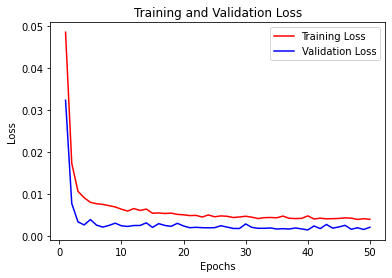

In [33]:
import matplotlib.pyplot as plt


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss', color='red')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_90914/1103801428.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, mean_abs_values, 'b', label='Mean Absolute Error', color='red')


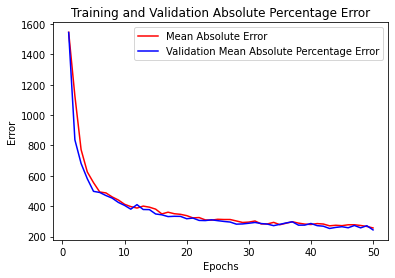

In [35]:
mean_abs_values = history_dict['mean_absolute_percentage_error']
val_mean_values = history_dict['val_mean_absolute_percentage_error']
plt.plot(epochs, mean_abs_values, 'b', label='Mean Absolute Error', color='red')
plt.plot(epochs, val_mean_values, 'b', label='Validation Mean Absolute Percentage Error')
plt.title('Training and Validation Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_90914/1711494966.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph1.plot(epochs, loss_values, 'b', label='Training Loss', color='red')
/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_90914/1711494966.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph2.plot(epochs, mean_abs_values, 'b', label='Mean Absolute Error', color='red')


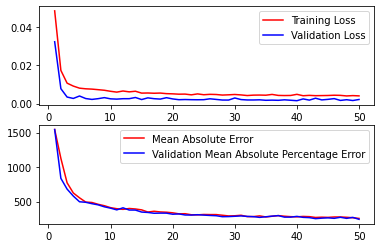

In [38]:
fig = plt.figure()

graph1 = fig.add_subplot(2, 1, 1)
graph2 = fig.add_subplot(2, 1, 2)

graph1.plot(epochs, loss_values, 'b', label='Training Loss', color='red')
graph1.plot(epochs, val_loss_values, 'b', label='Validation Loss')

graph1.legend(loc='best')
graph2.plot(epochs, mean_abs_values, 'b', label='Mean Absolute Error', color='red')
graph2.plot(epochs, val_mean_values, 'b', label='Validation Mean Absolute Percentage Error')

graph2.legend(loc='best')


NOTE3: Since model is not overfitting, I will add more units in layers and change optimizer to adam.

In [9]:
from tensorflow.keras.optimizers import Adam

In [10]:
# Defining a function for creating new model with increased capacity.
def create_btc_model_increased(hp):
    
    model = Sequential()

    hp_units_first = hp.Int('units_first_hidden', min_value=192, max_value=224, step=16)
    hp_units_second = hp.Int('units_second_hidden', min_value=160, max_value=192, step=16)
    hp_units_third = hp.Int('units_third_hidden', min_value=32, max_value=128, step=16)

    hp_drop_rate = hp.Float('rate', min_value=0.4, max_value=0.6, step=0.1)
    hp_recurrent_drop_rate = hp.Float('recurrent_rate', min_value=0.3, max_value=0.6, step=0.1)

    model.add(LSTM(units=hp_units_first, input_shape=(90, 6), activation='relu', return_sequences=True, recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(LSTM(units=hp_units_second, activation='relu', return_sequences=True, recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(LSTM(units=hp_units_third, activation='relu', recurrent_dropout=hp_recurrent_drop_rate))
    model.add(Dropout(hp_drop_rate))
    model.add(Dense(7, activation='relu'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

    return model

In [11]:
# Creating a tuner(RandomSearch) for new model.
tuner = kt.RandomSearch(create_btc_model_increased,
                    objective= kt.Objective('val_mean_absolute_percentage_error', 'min'),
                    max_trials=5,
                    directory='my_tuner',
                    project_name='btc_model_tune_increased')

INFO:tensorflow:Reloading Oracle from existing project my_tuner/btc_model_tune_increased/oracle.json


2022-05-07 14:08:43.934195: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from my_tuner/btc_model_tune_increased/tuner0.json


In [40]:
tuner.search(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation))

Trial 5 Complete [00h 21m 18s]
val_mean_absolute_percentage_error: 55.9479866027832

Best val_mean_absolute_percentage_error So Far: 51.9295768737793
Total elapsed time: 01h 53m 23s
INFO:tensorflow:Oracle triggered exit


NOTE4: Validation mean absolute percentage error per element is = %7.4(51.9/7). Which I consider good with 3485 total inputs(limited data).

In [12]:
# Creating the new model.
best_hyps = tuner.get_best_hyperparameters()[0]
model_increased = create_btc_model_increased(best_hyps)

In [13]:
history = model_increased.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_validation, y_validation))

Epoch 1/50
84/84 [==============================] - 31s 321ms/step - loss: 0.0202 - mean_absolute_percentage_error: 487.4854 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 154.0395
Epoch 2/50
84/84 [==============================] - 27s 326ms/step - loss: 0.0057 - mean_absolute_percentage_error: 129.4487 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 49.3248
Epoch 3/50
84/84 [==============================] - 27s 316ms/step - loss: 0.0049 - mean_absolute_percentage_error: 92.6484 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 54.2972
Epoch 4/50
84/84 [==============================] - 27s 318ms/step - loss: 0.0039 - mean_absolute_percentage_error: 78.1848 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 53.5964
Epoch 5/50
84/84 [==============================] - 27s 319ms/step - loss: 0.0036 - mean_absolute_percentage_error: 66.2559 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 55.7019
Epoch 6/50
84/84 [==============================] - 

In [14]:
# Analyzing the new model.
evaluation_increased = model_increased.evaluate(test_datas[:, :90, :], test_datas[:, 90:, 0])

1/1 [==============================] - 1s 958ms/step - loss: 0.0052 - mean_absolute_percentage_error: 8.5262


In [15]:
history_dict_increased = history.history
loss_values_increased = history_dict_increased['loss']
val_loss_values_increased = history_dict_increased['val_loss']
epochs_increased = range(1, len(loss_values_increased) + 1)
mean_abs_values_increased = history_dict_increased['mean_absolute_percentage_error']
val_mean_values_increased = history_dict_increased['val_mean_absolute_percentage_error']

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_1997/2040386990.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph1.plot(epochs_increased, loss_values_increased, 'b', label='Training Loss', color='red')
/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_1997/2040386990.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph2.plot(epochs_increased, mean_abs_values_increased, 'b', label='Mean Absolute Error', color='red')


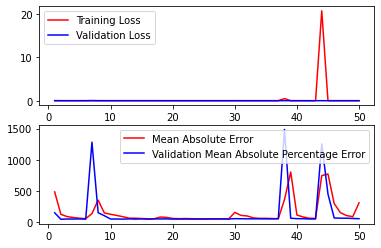

In [17]:
fig = plt.figure()

graph1 = fig.add_subplot(2, 1, 1)
graph2 = fig.add_subplot(2, 1, 2)

graph1.plot(epochs_increased, loss_values_increased, 'b', label='Training Loss', color='red')
graph1.plot(epochs_increased, val_loss_values_increased, 'b', label='Validation Loss')
graph1.legend(loc='best')

graph2.plot(epochs_increased, mean_abs_values_increased, 'b', label='Mean Absolute Error', color='red')
graph2.plot(epochs_increased, val_mean_values_increased, 'b', label='Validation Mean Absolute Percentage Error')
graph2.legend(loc='best')

In [31]:
val_mean_values_increased.index(min(val_mean_values_increased[3:]))

5

NOTE5: Increased model overshoots 3 times, after epoch 5, 37 and 43 and finds other or same local minimas, however as we can see min value for validation percentage error is at epoch 5. SO: 5 is best number for epochs.

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_1997/592049575.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph1.plot(epochs_increased[:30], loss_values_increased[:30], 'b', label='Training Loss', color='red')
/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_1997/592049575.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  graph2.plot(epochs_increased[:30], mean_abs_values_increased[:30], 'b', label='Mean Absolute Error', color='red')


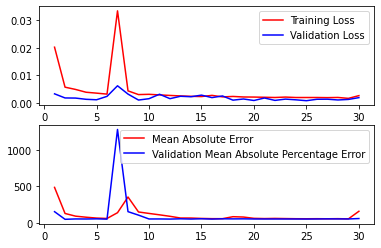

In [24]:
fig = plt.figure()

graph1 = fig.add_subplot(2, 1, 1)
graph2 = fig.add_subplot(2, 1, 2)

graph1.plot(epochs_increased[:30], loss_values_increased[:30], 'b', label='Training Loss', color='red')
graph1.plot(epochs_increased[:30], val_loss_values_increased[:30], 'b', label='Validation Loss')
graph1.legend(loc='best')

graph2.plot(epochs_increased[:30], mean_abs_values_increased[:30], 'b', label='Mean Absolute Error', color='red')
graph2.plot(epochs_increased[:30], val_mean_values_increased[:30], 'b', label='Validation Mean Absolute Percentage Error')
graph2.legend(loc='best')

In [26]:
evaluation_data = np.copy(test_datas[:, 90:, 0]) * normalization_list[0][1]

predictions_increased = model_increased.predict(test_datas[:, :90, :])

predictions_increased = predictions_increased * normalization_list[0][1]

In [28]:
data = {'predictions' : predictions_increased[0], 'real' : evaluation_data[0]}
df_eval_increased_1 = pd.DataFrame(data=data)
df_eval_increased_1

,predictions,real
0,39041.296875,39702.999119
1,39756.222656,40803.001019
2,38870.429688,41503.000764
3,39083.507812,41367.999031
4,39702.613281,40482.001101
5,39032.214844,39709.000359
6,39754.664062,39649.000036


In [32]:
data = {'predictions' : predictions_increased[5], 'real' : evaluation_data[5]}
df_eval_increased_2 = pd.DataFrame(data=data)
df_eval_increased_2

,predictions,real
0,41558.878906,40077.998120
1,42274.792969,41133.000784
2,41205.910156,39936.000978
3,41495.941406,40560.001119
4,42110.050781,40382.000563
5,41392.867188,39702.999119
6,42189.882812,40803.001019


NOTE6: This architecture would have good accuracy after only 5 epochs:

In [33]:
# Further notes on this model.
model_completed = create_btc_model_increased(best_hyps)

In [34]:
history = model_completed.fit(x=X_train, y=y_train, epochs=5, validation_data=(X_validation, y_validation))

Epoch 1/5
84/84 [==============================] - 41s 435ms/step - loss: 0.0164 - mean_absolute_percentage_error: 420.6817 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 226.9847
Epoch 2/5
84/84 [==============================] - 34s 406ms/step - loss: 0.0055 - mean_absolute_percentage_error: 175.9052 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 80.8877
Epoch 3/5
84/84 [==============================] - 38s 448ms/step - loss: 0.0045 - mean_absolute_percentage_error: 136.3020 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 80.0009
Epoch 4/5
84/84 [==============================] - 35s 420ms/step - loss: 0.0041 - mean_absolute_percentage_error: 90.1431 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 54.1796
Epoch 5/5
84/84 [==============================] - 34s 410ms/step - loss: 0.0037 - mean_absolute_percentage_error: 76.4684 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 51.7094


In [37]:
evaluation_completed = model_completed.evaluate(test_datas[:, :90, :], test_datas[:, 90:, 0])

1/1 [==============================] - 0s 88ms/step - loss: 0.0082 - mean_absolute_percentage_error: 10.5374


In [38]:
predictions_completed = model_completed.predict(test_datas[:, :90, :])

predictions_completed = predictions_completed * normalization_list[0][1]

In [39]:
data = {'predictions' : predictions_completed[0], 'real' : evaluation_data[0]}
df_eval_1 = pd.DataFrame(data=data)
df_eval_1

,predictions,real
0,39071.863281,39702.999119
1,39505.402344,40803.001019
2,38759.343750,41503.000764
3,38414.488281,41367.999031
4,39134.195312,40482.001101
5,38762.976562,39709.000359
6,39528.851562,39649.000036


In [40]:
data = {'predictions' : predictions_increased[5], 'real' : evaluation_data[5]}
df_eval_2 = pd.DataFrame(data=data)
df_eval_2

,predictions,real
0,41558.878906,40077.998120
1,42274.792969,41133.000784
2,41205.910156,39936.000978
3,41495.941406,40560.001119
4,42110.050781,40382.000563
5,41392.867188,39702.999119
6,42189.882812,40803.001019
